In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, PILToTensor, Lambda

from tqdm.notebook import tqdm

class BinaryLinearFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, W, alpha):
        """ X : (batch_size, in_features)
            W : (in_features, out_features)
            alpha : (out_features,)
        """
        X_bin = torch.sign(X)
        W_bin = torch.sign(W)
        XW_bin = X_bin.mm(W_bin)
    
        assert(torch.all(alpha >= 0))

        ctx.save_for_backward(X_bin, W_bin, X, W, alpha)
        return XW_bin * alpha[None, :]

    @staticmethod
    def backward(ctx, dL_dY):
        """ dL_dZ : (batch_size, out_featuers)
            dL_dX : (batch_size, in_features)
            dL_dW : (in_features, out_features)
            dL_dalpha : (out_features,)
        """
        X_bin, W_bin, X, W, alpha = ctx.saved_tensors

        dL_dX = None
        dL_dW = None
        dL_dalpha = None

        if ctx.needs_input_grad[0]:
            dL_dX = dL_dY.mm(W_bin) * alpha[None, :] * (1 - torch.tanh(X).pow(2))
        
        if ctx.needs_input_grad[1]:
            dL_dW = X_bin.T.mm(dL_dY) * alpha[None, :] * (1 - torch.tanh(W).pow(2))

        if ctx.needs_input_grad[2]:
            dL_dalpha = (X_bin.mm(W_bin) * dL_dY).sum(axis=0)

        return dL_dX, dL_dW, dL_dalpha

class BinaryLinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super().__init__()
        
        self.W = nn.Parameter(torch.empty(in_features, out_features))
        self.alpha = nn.Parameter(torch.empty(out_features))

        nn.init.xavier_uniform_(self.W)
        self.alpha.data = self.W.abs().mean(axis=0)

        self.func = BinaryLinearFunc.apply

    def forward(self, X):
        self.alpha.data.relu_() # alpha should be > 0

        return self.func(X, self.W, self.alpha)
    
def create_net(n_hidden=4, input_dim=784, out_dim=10, hid_dim=128, binary=False):
    net = nn.Sequential()

    net.add_module("input", nn.Linear(input_dim, hid_dim, bias=False))
    
    if not binary:
        net.add_module("input_relu", nn.ReLU())

    for i in range(n_hidden):
        if not binary:
            net.add_module(f"hidden_{i}", nn.Linear(hid_dim, hid_dim, bias=False))
            net.add_module(f"relu_{i}", nn.ReLU())
        else:
            net.add_module(f"hidden_{i}", BinaryLinearLayer(hid_dim, hid_dim))


    net.add_module("output", nn.Linear(hid_dim, 10, bias=False))

    return net

In [2]:
tfm = Compose([
    PILToTensor(),
    Lambda(lambda x: x.flatten() / 255),
])

# train_data = MNIST("mnist", train=True, download=True, transform=tfm)
# test_data = MNIST("mnist", train=False, download=True, transform=tfm)

train_data = CIFAR10("mnist", train=True, download=True, transform=tfm)
test_data = CIFAR10("mnist", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

input_dim = train_data[0][0].shape[0]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train_epoch(net, optim, loss_fn, log, step):
    for image, label in train_loader:
        image = image.cuda()
        label = label.cuda()

        output = net(image)
        loss = loss_fn(output, label)
        
        log["train step"].append(step[0])
        log["train loss"].append(loss.item())
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        step[0] += 1

@torch.no_grad()
def test(net, loss_fn, log, step):
    total_loss = 0
    total_steps = 0

    total_acc = 0
    total_samples = 0

    for image, label in test_loader:
        image = image.cuda()
        label = label.cuda()

        output = net(image)
        loss = loss_fn(output, label)
        total_loss += loss.item()
        total_steps += 1

        total_acc += (output.argmax(dim=1) == label).sum().item()
        total_samples += image.shape[0]

    log["test step"].append(step[0])
    log["test loss"].append(total_loss / total_steps)
    log["test accuracy"].append(total_acc / total_samples)

In [4]:
simple_net = create_net(input_dim=input_dim).cuda()

optim = torch.optim.Adam(simple_net.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

log = {
    "train step": [],
    "train loss": [],
    "test step": [],
    "test loss": [],
    "test accuracy": [],
}

step = [0]
n_epochs = 10
max_step = n_epochs * len(train_loader)

for epoch in range(n_epochs):
    if step[0] == 0:
        test(simple_net, loss_fn, log, step)

    train_epoch(simple_net, optim, loss_fn, log, step)
    test(simple_net, loss_fn, log, step)

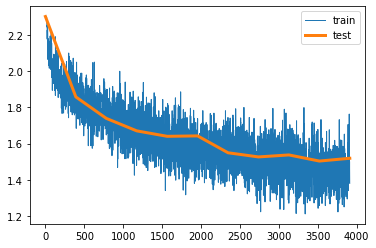

In [5]:
from matplotlib import pyplot as plt

plt.plot(log["train step"], log["train loss"], lw=1, label="train")
plt.plot(log["test step"], log["test loss"], lw=3, label="test")
plt.legend();

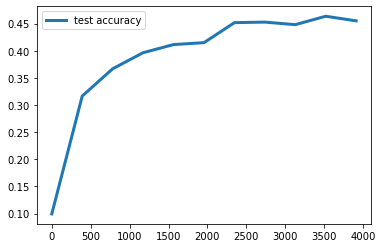

In [6]:
plt.plot(log["test step"], log["test accuracy"], lw=3, label="test accuracy")
plt.legend();

In [7]:
bin_net = create_net(input_dim=input_dim, hid_dim=2048, binary=True).cuda()

optim = torch.optim.Adam(bin_net.parameters(), lr=1e-4)

bin_log = {
    "train step": [],
    "train loss": [],
    "test step": [],
    "test loss": [],
    "test accuracy": [],
}

step = [0]
n_epochs = 10
max_step = n_epochs * len(train_loader)

min_t = 1
max_t = 2

for epoch in range(n_epochs):
    if step[0] == 0:
        test(bin_net, loss_fn, bin_log, step)

    train_epoch(bin_net, optim, loss_fn, bin_log, step)
    test(bin_net, loss_fn, bin_log, step)

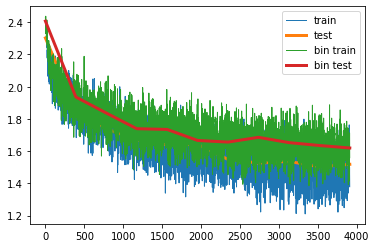

In [8]:
plt.plot(log["train step"], log["train loss"], lw=1, label="train")
plt.plot(log["test step"], log["test loss"], lw=3, label="test")

plt.plot(bin_log["train step"], bin_log["train loss"], lw=1, label="bin train")
plt.plot(bin_log["test step"], bin_log["test loss"], lw=3, label="bin test")

plt.legend();

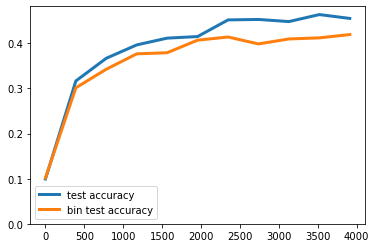

In [9]:
plt.plot(log["test step"], log["test accuracy"], lw=3, label="test accuracy")
plt.plot(bin_log["test step"], bin_log["test accuracy"], lw=3, label="bin test accuracy")
plt.ylim((0, None))
plt.legend();
